## Package installation

In [ ]:
# Training progress bar
!pip install -q qqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.5 MB/s eta 0:00:00


## Downloading data

In [ ]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

Cloning into 'ml2023spring-hw8'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 1.69 KiB | 576.00 KiB/s, done.
Filtering content: 100% (2/2), 1.36 GiB | 53.16 MiB/s, done.


# Import packages

In [ ]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [ ]:

train = np.load('ml2023spring-hw8/trainingset.npy', allow_pickle=True)
test = np.load('ml2023spring-hw8/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [ ]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(), 
            nn.Linear(256, 64), 
            nn.ReLU(), 
            nn.Linear(64, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(), 
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x, latent):
        x = self.encoder(x)
        #latent = self.decoder[0](latent)  
        x += latent
        x = self.decoder(x)
        return x

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [ ]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# result


In [ ]:
# load dataset
train = np.load('ml2023spring-hw8/trainingset.npy', allow_pickle=True)
eval_batch_size = 128
model_type = 'fcn'

# load dataset
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=128)

data = next(iter(train_dataloader))
img = data.float().cuda()
img = img.view(img.shape[0], -1)
latent = torch.zeros((eval_batch_size, 256)).cuda()

# load trained model
model = fcn_autoencoder().cuda()


RuntimeError: ignored

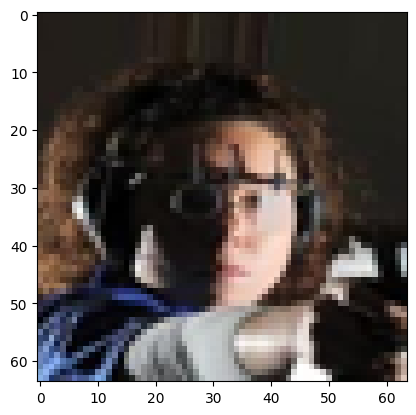

In [ ]:
import matplotlib.pyplot as plt
# Original image
origin = img[0].detach().cpu().numpy().reshape(3, 64, 64).transpose(1, 2, 0) + 1
origin = (origin * 255. / 2.).astype(int)
plt.imshow(origin)
plt.savefig("origin.png")

# Model Output
output = model(img, latent)
output_origin = output[0].detach().cpu().numpy().reshape(3, 64, 64).transpose(1, 2, 0) + 1
output_origin = (output_origin * 255. / 2.).astype(int)
plt.imshow(output_origin)
plt.savefig("output.png")

# change 1
latent[0] += 1.5
output_t1 = model(img, latent)
output_t1_img = output_t1[0].detach().cpu().numpy().reshape(3, 64, 64).transpose(1, 2, 0) + 1
output_t1_img = (output_t1_img * 255. / 2.).astype(int)
plt.imshow(output_t1_img)
plt.savefig("output_t1.png")

# change 2
output_t2 = model(img, latent)
output_t2_img = output_t2[0].detach().cpu().numpy().reshape(3, 64, 64).transpose(1, 2, 0) + 1
output_t2_img = (output_t2_img * 255. / 2.).astype(int)
plt.imshow(output_t2_img)
plt.savefig("output_t2.png")